In [1]:
import numpy as np 
from numpy.random import randint
from typing import Dict, List
from matplotlib import pyplot as plt
import cv2
import keras
from keras.datasets import mnist 

Using TensorFlow backend.


In [0]:
def load_mnist_data() -> Dict[int,List[np.ndarray]]:
    '''
    Loads the MNIST dataset and orginising it in a dictionary.

    # Returns
        Dictionary where the labels are the keys and data stored on each entry as a list og numpy.ndarray
    '''
    numbers = {}
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    data_images = np.append(x_train,x_test,axis=0)
    data_labels = np.append(y_train,y_test,axis=0)

    for img, label in zip(data_images, data_labels):
        if label not in numbers.keys():
            numbers[label] = []
        numbers[label] += [img]

    return numbers

def plot_data_dict(data:Dict[int,np.ndarray],figsize=[12,5]) -> None:
    '''
        Plots the data 
        @param: data - Dict[int,np.ndarray]
    '''
    cols = 5
    rows = (len(data.keys())/cols) + 1
    plt.figure(figsize=figsize)
    for index,key in enumerate(data.keys()):
        plt.subplot(rows,cols,index+1)
        plt.imshow(data[key][0],cmap = 'gray')
        plt.axis('off')
        plt.title(key)

    plt.show()
            

def scale_minMax(image):
    mini,maxi = np.min(image),np.max(image)
    return (image - mini)/(maxi-mini)

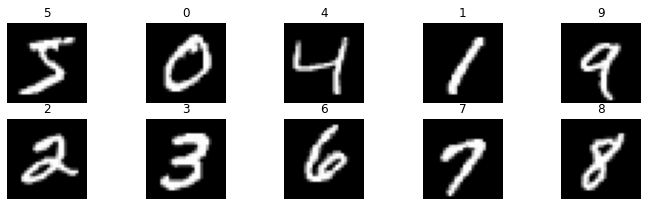

In [0]:
data = load_mnist_data()
plot_data_dict(data)


In [0]:
def build_dataset(numbers, amount=6000):
    dataset = {}
    print('Building: 0',end='')
    for hundreds,tens,unit in np.ndindex(2,10,10):
        key = 100*hundreds + 10*tens + unit

        if(key > 100):      
            break
    
        nset = np.array([])
        
        while len(nset) < amount:
            r_unit, r_tens, r_hundreds = randint(0,len(numbers[unit])),randint(0,len(numbers[tens])),randint(0,len(numbers[hundreds]))
            permutation = np.concatenate([numbers[hundreds][r_hundreds],numbers[tens][r_tens],numbers[unit][r_unit]], axis=1)
            if nset.size == 0:    
                nset = permutation.reshape([1,28,84])
            else:
                nset = np.append(nset, [permutation], axis=0)
                
            if len(nset) % amount == 0:
                nset = np.unique(nset,axis=0) # to make sure there are no redundent permutation of an image    

        dataset[key] = nset
        print('.', end='')

    print("100")
    return dataset


Building: 0.....................................................................................................100


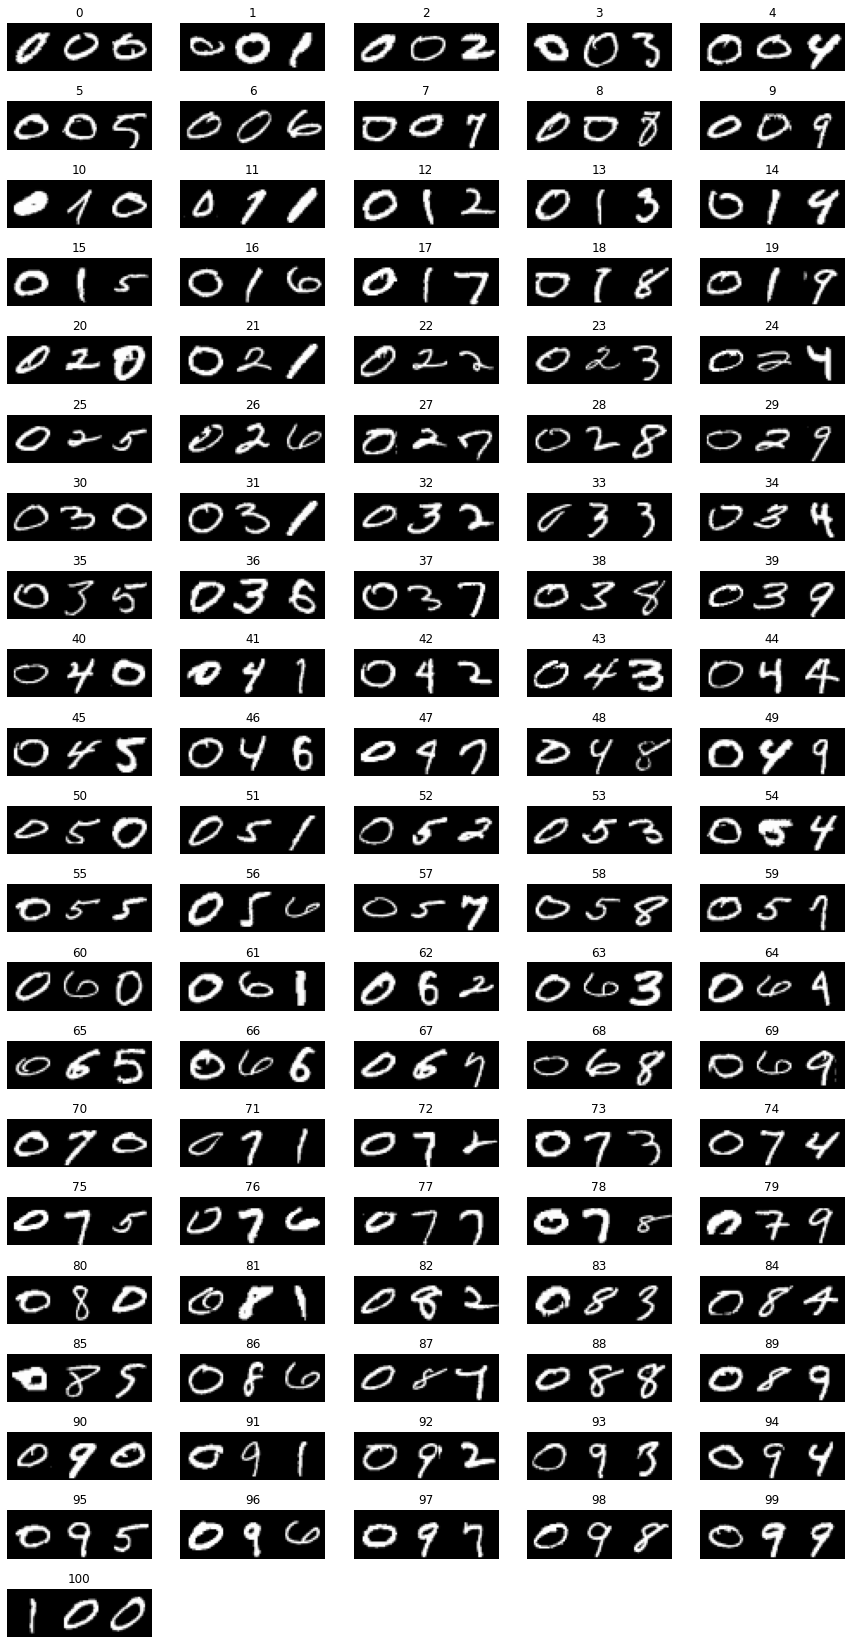

In [0]:
new_data = build_dataset(data)
plot_data_dict(new_data,figsize=[15,30])

In [0]:
class Augmentation(object): 
    
    @staticmethod
    def flip(img:np.ndarray,axis:int) -> np.ndarray:
        return cv2.flip(img,axis)

    @staticmethod
    def rotate(img, angle:float)-> np.ndarray:
        centerH,centerW = img.shape[0]//2,img.shape[1]//2
        rotation_matrix = cv2.getRotationMatrix2D((centerW, centerH), angle, 1)
        return cv2.warpAffine(img, rotation_matrix, (img.shape[1],img.shape[0]))

    @staticmethod
    def gaussian_blur(img, ksize:int,sigma:int) -> np.ndarray:
        return cv2.GaussianBlur(img,ksize=(ksize,ksize),sigmaX=sigma, borderType=cv2.BORDER_DEFAULT)

    @staticmethod
    def median_blur(img, ksize:int) -> np.ndarray:
        return cv2.medianBlur(img,ksize)

    @staticmethod
    def zoom(img, zoom_factor:int)-> np.ndarray:

        height, width = img.shape[:2] 
        new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)

        h1, w1 = (new_height - height) // 2,(new_width - width) // 2
        h2, w2 = h1 + height, w1 + width

        pos = (np.array([h1, w1])/ zoom_factor).astype(int)
        size = (np.array([h2-h1,w2-w1]) / zoom_factor).astype(int)

        cropped_img = Augmentation.crop(img, tuple(pos), tuple(size))
        
        return cv2.resize(cropped_img, (width,height))

    @staticmethod
    def crop(img, pos:tuple, size:tuple) -> np.ndarray:
        newH = np.min([pos[0]+size[0],img.shape[0]])
        newW = np.min([pos[1]+size[1],img.shape[1]])     
        return img[pos[0]:newH,pos[1]:newW]


    @staticmethod
    def sobel(image,dx=1,dy=1):
        ddepth = cv2.CV_64F
        if len(image.shape) == 3:
             image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

        sobelx = cv2.Sobel(image,ddepth=ddepth,dx=1,dy=0)   
        if dx == 1 and dy == 0:
            return sobelx

        sobely = cv2.Sobel(image,ddepth=ddepth,dx=0,dy=1)
        if dx == 0 and dy == 1:
            return sobely
        return cv2.sqrt(cv2.addWeighted(cv2.pow(sobelx, 2.0), 1.0, cv2.pow(sobely,2.0), 1.0, 0.0))

    @staticmethod
    def canny(image,min_thresh=100,max_thresh=200):
        if len(image.shape) == 3:
             image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        return cv2.Canny(image,min_thresh,max_thresh)

    @staticmethod
    def average_blur(image,ksize=3):
        kernel = np.ones([ksize,ksize], dtype=np.float32)/ksize**2
        return cv2.filter2D(image,-1,kernel)

    @staticmethod
    def salt_n_pepper_noise(image, s_vs_p = 0.5, amount = 0.004):
        out = np.copy(image)
        if len(image.shape) < 3:
            out = out.reshape([out.shape[0],out.shape[1],1])
        # Add salt
        salt = np.ceil(amount * image.size * s_vs_p).astype(int)
        coords = [np.random.randint(0, i - 1, size=salt) for i in image.shape]
        out[coords[0], coords[1], :] = 255

        # Add pepper
        pepper = np.ceil(amount * image.size * (1. - s_vs_p)).astype(int)
        coords = [np.random.randint(0, i - 1, size=pepper) for i in image.shape]
        out[coords[0], coords[1], :] = 0

        return out.reshape(image.shape)

    @staticmethod
    def guassian_noise(img,mean=0,sigma=5):
        noisey_image = img.copy()
        rows,cols = noisey_image.shape[:2]
        shape_original_image = 1 if len(noisey_image.shape) <= 2 else noisey_image.shape[2]
        if shape_original_image == 1:
            noise = np.random.normal(loc=mean, scale=sigma, size=(rows, cols))
            noisey_image[:rows, :cols] += noise.astype(noisey_image.dtype)
        else:
            noise = np.random.normal(loc=mean, scale=sigma,
                                     size=(rows, cols, noisey_image.shape[2]))
            for color in range(noisey_image.shape[2]):
                noisey_image[:rows, :cols] += noise.astype(noisey_image.dtype)

        return noisey_image

    @staticmethod
    def translate(image,dx=100,dy=50):
        rows,cols = image.shape[:2]
        M = np.float32([[1,0,dx],[0,1,dy]])
        return cv2.warpAffine(image,M,(cols,rows))
        
    @staticmethod
    def invert(image):
        return np.max(image)-image

    @staticmethod
    def emboss(image):
        kernel=np.array([[-2, -1, 0], 
                         [-1,  1, 1], 
                         [ 0,  1, 2]])
        return cv2.filter2D(image, -1, kernel)

    @staticmethod
    def erode(image, ksize=3,iterations=1):
        kernel = np.ones((ksize,ksize),np.uint8)
        return cv2.erode(image,kernel,iterations = iterations)
    
    @staticmethod
    def dilate(image, ksize=3,iterations=1):
        kernel = np.ones([ksize,ksize],np.uint8)
        return cv2.dilate(image,kernel,iterations = iterations)

    @staticmethod
    def scale(image,fx=0.5,fy=0.5,resize=False):
        rows,cols = image.shape[:2]
        scaled_image = cv2.resize(image,None,fx=fx, fy=fy, interpolation=cv2.INTER_CUBIC)
        if resize:
            scaled_image = cv2.resize(scaled_image,(cols,rows), interpolation=cv2.INTER_CUBIC)

        return scaled_image



In [0]:
class RandomAugmentation(Augmentation):
    

    noise = [func for func in dir(Augmentation) 
                        if callable(getattr(Augmentation, func)) 
                        and 'noise' in func]
    
    blur = [func for func in dir(Augmentation) 
                        if callable(getattr(Augmentation, func)) 
                        and 'blur' in func]
    
    augmentations = [func for func in dir(Augmentation) 
                        if callable(getattr(Augmentation, func)) 
                        and not func.startswith("__")
                        and 'blur' not in func 
                        and 'noise' not in func] + ['noise','blur']

    def __init__(self,images:List[np.ndarray], N:List[str], M:List[float]):
        ''' 
            N functions to use
            M propabilities
        '''
        self.images = images
        self.N = N
        self.M = M
        self.augmented_images = {}

    def random_noise(self,img):
        aug = np.random.choice(self.noise,1)
        if aug == 'guassian_noise':
            return 'guassian_noise,', super().guassian_noise(img)        
        elif aug == 'salt_n_pepper_noise':
            amount = np.random.uniform(0.0001,0.3,size=1)
            s_vs_p = np.random.uniform(0.1,0.6,size=1)
            return 'salt_n_pepper_noise,', super().salt_n_pepper_noise(img, s_vs_p, amount)

    def random_blur(self,img):
        aug = np.random.choice(self.blur,1)
        if aug == 'average_blur':
            ksize = np.random.randint(1,11)*2 +1
            return 'average_blur,', super().average_blur(img,ksize)

        elif aug == 'gaussian_blur':
            ksize = np.random.randint(1,11)*2 +1
            sigma = np.random.randint(1,9)
            return  'gaussian_blur,', super().gaussian_blur(img,ksize=ksize,sigma=sigma)

        elif aug ==  'median_blur':
            ksize = np.random.randint(1,11)*2 +1
            return 'median_blur,', super().median_blur(img, ksize=ksize)

    def augment_image(self, key, img, permutations:list):
        key+=':['

        if 'noise' in permutations:
            aug, img = self.random_noise(img)
            key+=aug
        
        if 'blur' in permutations:
            aug, img = self.random_blur(img)
            key+=aug

        if 'flip' in permutations:
            axis = np.random.randint(-1,1,1)
            img = super().flip(img=img,axis=axis)
            key+='flip,'
        
        if 'rotate' in permutations:
            angle = np.random.uniform(0, 360)
            img = super().rotate(img,angle=angle)
            key+='rotate,'

        if 'zoom' in permutations: 
            zoom = np.random.uniform(1,3)
            img = super().zoom(img, zoom_factor=zoom)
            key+='zoom,'

        if 'crop' in permutations:
            x = np.random.randint(10,img.shape[0])
            y = np.random.randint(10,img.shape[1])
            h = np.random.randint(10,img.shape[0])
            w = np.random.randint(10,img.shape[1])
            pos=(x,y)
            size=(h,w)
            img = super().crop(img, pos, size)
            key+='crop,'

        if 'emboss' in permutations:
            img = super().emboss(img)
            key+='emboss,'

        if 'canny' in permutations:
            tresholds = [[50,150],[100,200],[150,250]]
            min_t,max_t = tresholds[randint(3)]
            img = super().canny(img,min_t,max_t)
            key+='canny,'

        if 'sobel' in permutations:
            sobel_type = [[1,0],[0,1],[1,1]]
            dx,dy = sobel_type[randint(3)]
            img = super().canny(img,dx,dy)
            key+='sobel,'

        if 'dilate' in permutations:
            ksize = np.random.randint(1,4)*2 +1
            img = super().dilate(img,ksize)
            key+='dilate,'

        if 'erode' in permutations:
            ksize = np.random.randint(1,4)*2 +1
            img = super().erode(img,ksize)
            key+='erode,'

        if 'invert' in permutations:
            img = super().invert(img)
            key+='invert,'

        if 'scale' in permutations:
            fx,fy = np.random.uniform(0.1,0.7,size = 2)
            resisze = np.random.choice([True,False],size=1)
            img = super().scale(img, fx, fy, resisze)
            key+='scale,'

        if 'translate' in permutations:
            dx = np.random.randint(10,20)
            dy = np.random.randint(10,20)
            img = super().translate(img, dx, dy)
            key+='translate,'

        self.augmented_images[key[:-1]+']'] = img
            
        
    def generate_augmented_images(self,num_of_augments=2,show = False):
        self.augmented_images = {}
        for index,img in enumerate(self.images):
            permutations = np.random.choice(self.N,num_of_augments,replace=False,p=self.M)
            self.augment_image(str(index), img, permutations)
        if show:
            self.show_augmented_images()
            
    def show_augmented_images(self):
        total = len(self.augmented_images.values())
        in_col = 5
        in_row = (total//in_col) + 1
        plt.figure(figsize=[20,40])
        for index,(k,v) in enumerate(self.augmented_images.items()):    
            plt.subplot(in_row, in_col, index+1)
            plt.title(k)
            plt.axis('off')
            plt.imshow(v,cmap='gray')
        plt.show()

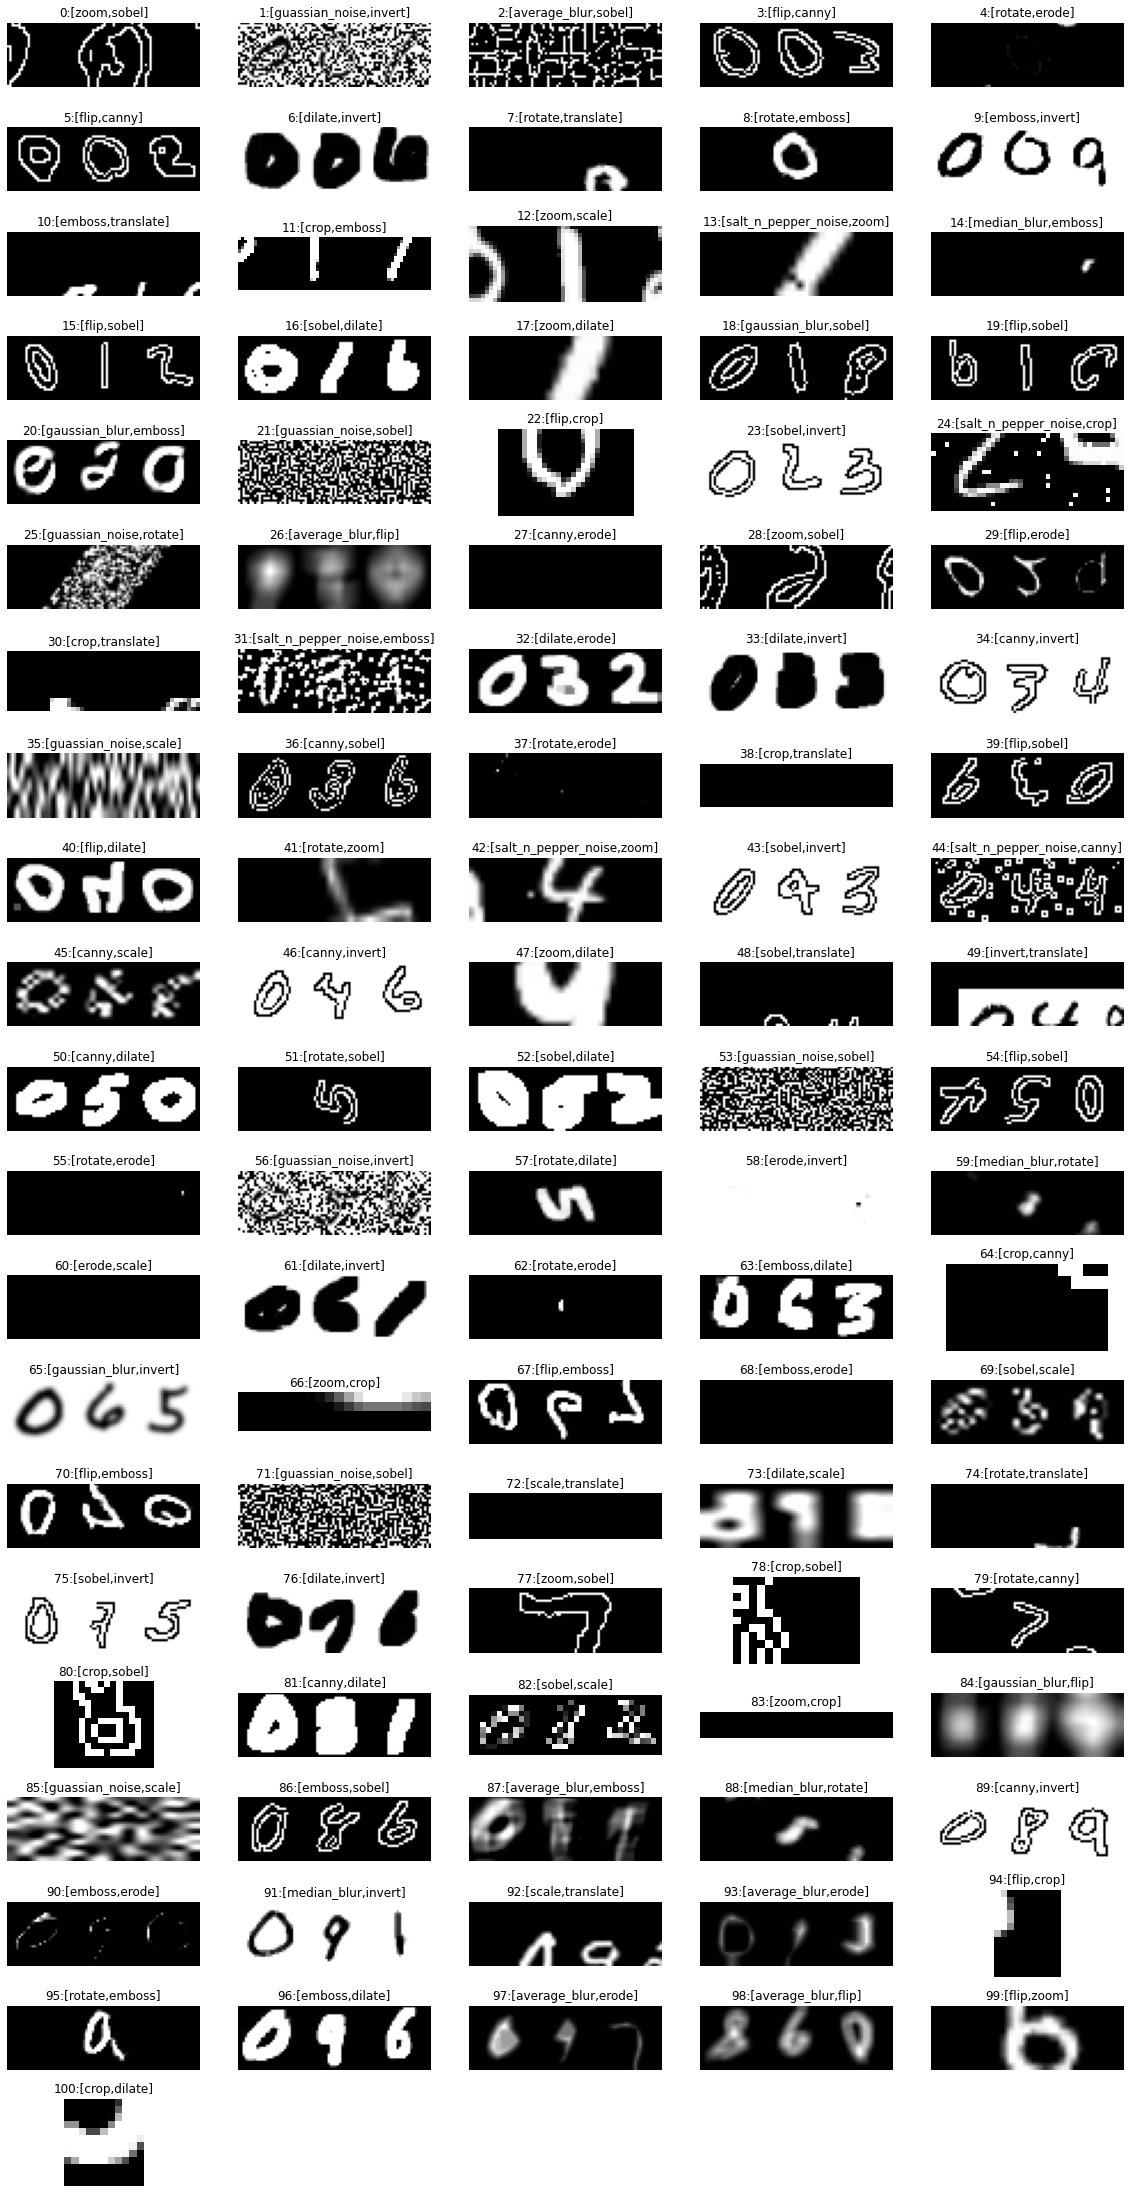

In [0]:
images = []
for k in new_data.keys():
    images.append(new_data[k][randint(len(new_data[k]))])
ra = RandomAugmentation(images,N=RandomAugmentation.augmentations,M=None)
ra.generate_augmented_images(2,True)

## בתרגיל זה טענו בסיס נתונים קיים של ספרות שממנו בנינו בסיס נתונים חדש של ספרות הבנויות מ 3 ספרות. לאחר מכן בניתי מחלקה אשר תעביר אוגמנטציות שונות באופן רנדומלי על תמונות. תפקיד האוגמטציות הוא עיוות ושינוי התמונה  ע"י אלגורתמים שונים אחר הצגה של אוגמטציות שונות ניתן היה לראות מה האוגמנטציות הלוונטיות לבסיס הנתונים שבניתי.

# אוגמנטציות רלונטיות
*   'canny' - אלגוריתם לזיהוי קשתות/קצוות 
*   'dilate' - עוזרת בהפחתת רעשים ע"י הגדלת קצוות בתמונה (ניתן להשתמש גם בזיהוי קצוות ע"י הפחתה בתונה המקורית)
*   'emboss' - הבלטת הצללים ניתן להיעזר גם בזיהוי קצוות
*   'invert' - היפוך צבעים
*   'rotate' - סיבוב  
*   'sobel' - אלגוריתם לזיהוי קשתות/קצוות
*   'translate' - הזזת התמונה
*   'zoom' - תקריב תמונה למרכז
*   'average_blur' -  אלגוריתם להחלקה והפחתת רעשים
*   'gaussian_blur' - אלגוריתם להחלקה והפחתת רעשים 
*   'median_blur' - אלגוריתם להחלקה והפחתת רעשים
*   'guassian_noise' - הוספת רעשים 
*   'salt_n_pepper_noise' - הוספת רעשים 

#####   במקרים בהם סט האימון (תמונות) שלנו קטן נוכל להגדיל אותו בעזרת הוספה של אוגמטציות (כמו רעשים החלקות הבלטת הקשתות וכו) לתמונות ובכך להוסיף תמונות חדשות לסט האימון. הוספת עוד דאטא תשפר את הביצועי המודל. אך נשים לב לאוגמטציות כמו 
rotate,translate,zoom 
##### שהן פונקציות שנרצה לשלוט במפרמטרים שלהן כי לעיתים הן יכולות להרוס תוכן התמונה.

```
```

# אוגמנטציות לא רלוונטית:
*   'crop' - חותך את התמונה במקום מסוים בגדול מסוים
*   'flip' - היפוך תמונה אנכית או אופקית
*   'erode' - פילטר זה מקטין את קצות התמונה (במקרה שלנו הוא יכול גם להעלים מספרים)
*   'scale' - הגדלת/הקטנת התמונה
##### האוגמנטציות הנ"ל אינן מועילות מפני שיכולות להרוס את מימדי התמונה ואת התוכן כמו העלמת מספרים או הפיכת המספרים ויכולים לפגוע באימון ובביצועי המודל



# refrences:
    - http://www.theobjects.com/dragonfly/dfhelp//Content/05_Image%20Processing/Morphology%20Filters.htm

    - https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html





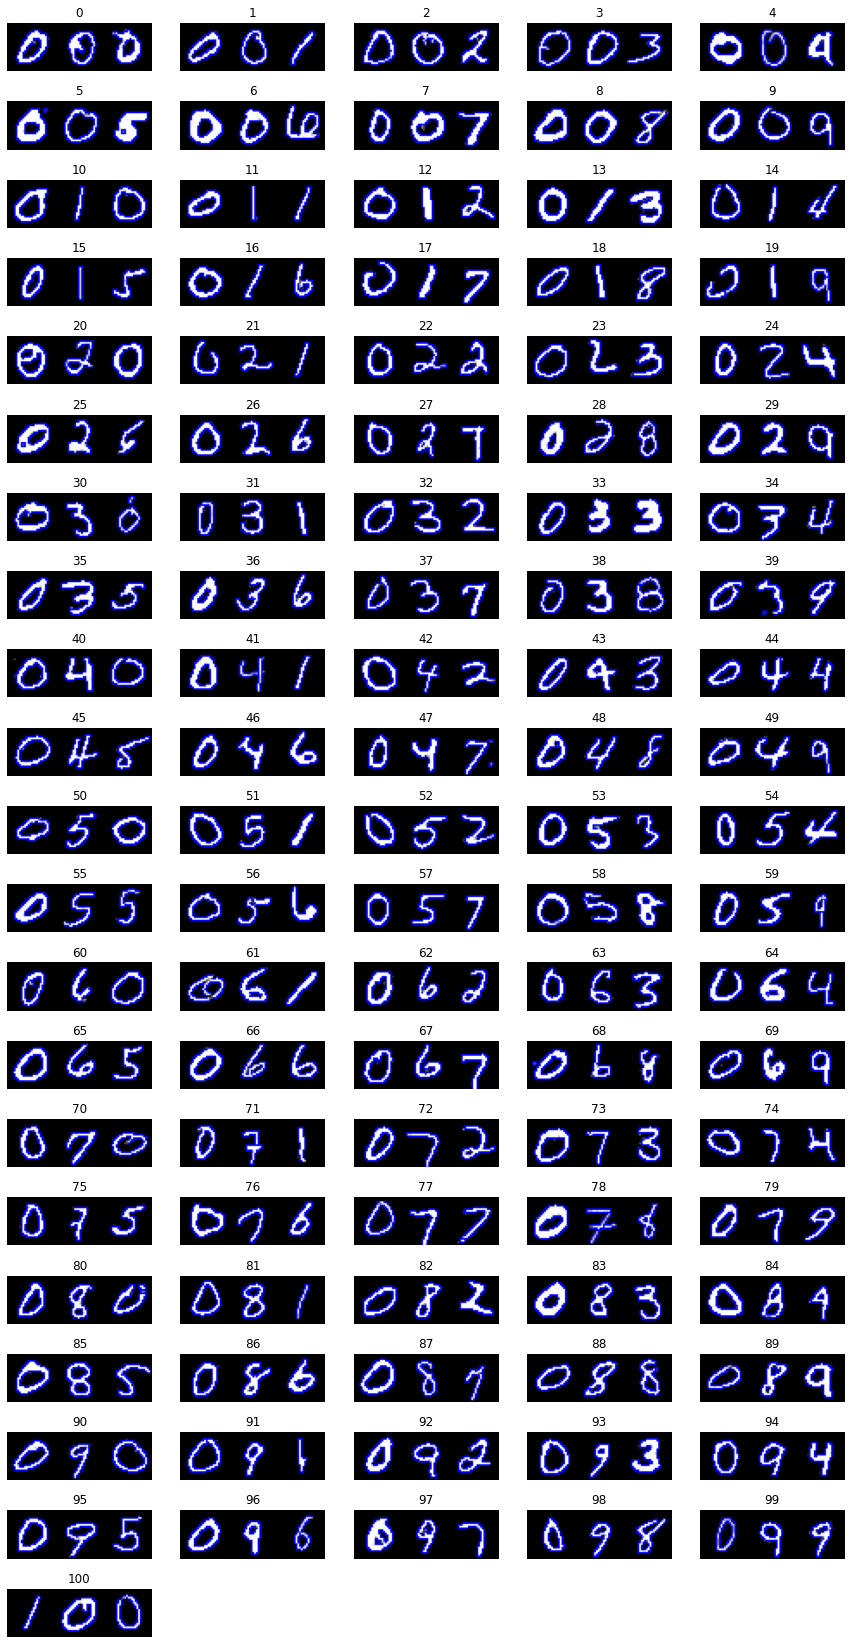

In [0]:
def show_contours(images):
    img_dict = {}
    for index,img in enumerate(images):
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

        img_draw = Augmentation.invert(img)
        edges = Augmentation.canny(img_draw,100,200)
        contours,_ = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        img_draw = Augmentation.invert(img_draw)
        img_draw = cv2.drawContours(img_draw,contours,-1,(0,0,255),1)
        img_dict[index] = [img_draw]

            
    plot_data_dict(img_dict,[15,30])

show_contours(images)  

### למציאת קונטורים השתמשתי באלגוריתם 
### canny
### אלגוריתם למציאת קשתות. בשביל לצייר את הקשתות העברתי את התמונה למימד 
### RGB 
### בכדי שאוכל להבליט את הקשתות שנמצאו

In [0]:
class RandomShapes():
    
    def __init__(self,size = 300):
        self.size = size
        self.triangles = []
        self.rectangles = []
        self.ellipses = []
        self.generate_shapes()

    
    def random_triangle(self):
        pt1 = np.array([randint(0,50), randint(0,50)])

        while True:
            pt2 = np.array([randint(0,50),randint(0,50)])
            if np.linalg.norm(pt1-pt2) >= 5:
                break

        while True:
            pt3 = [randint(0,50),randint(0,50)]
            if abs((pt1[0]*(pt2[1] - pt3[1]) + pt2[0]*(pt3[1] - pt1[1]) + pt3[0]*(pt1[1]-pt2[1]))/2) >= 30: # rand area
                color = (randint(1, 255),randint(1, 255),randint(1, 255))
                img = np.zeros((50, 50, 3),dtype= 'uint8')
                pts = np.array([pt1,pt2,pt3])
                return  cv2.polylines(img,[pts],True,color,1) 


    def random_rectangle(self):
        while True:
            pt1,pt2 = (randint(0,50), randint(0,50)), (randint(0,50), randint(0,50))
            if abs((abs(pt1[0] - pt2[0])*abs(pt1[1] - pt2[1]))) >= 30:
                img = np.zeros((50, 50, 3), dtype= 'uint8')
                color = (randint(1, 255),randint(1, 255),randint(1, 255))
                return cv2.rectangle(img,pt1,pt2,color,1)

    def random_ellipse(self):  
        image = np.zeros((50, 50, 3),dtype= 'uint8')
        h, w = image.shape[:2]
        center_y = np.random.randint(1,h-1)
        center_x = np.random.randint(1, w-1)
        rotatation_angle = 0 
        axis_x = min(center_y, abs(h-center_y-1))
        axis_y = min(center_x,abs(w-center_x-1))

        angle = randint(1, 360)
        color = (randint(0, 255),randint(0, 255),randint(0, 255))
        return cv2.ellipse(image, (center_x, center_y), (axis_x , axis_y), angle, 0, 360, color, 1)


    def generate_shapes(self):
        for i in range(self.size):
            self.triangles.append(self.random_triangle())

        for i in range(self.size):
            self.rectangles.append(self.random_rectangle())

        for i in range(self.size):
            self.ellipses.append(self.random_ellipse())
        

    def load_data(self, split=0.8):
   
        X = np.concatenate([self.triangles,self.rectangles,self.ellipses], axis=0)
        y = np.concatenate([['triangle']*len(self.triangles)
                            ,['rectangle']*len(self.rectangles)
                            ,['ellipse']*len(self.ellipses)], axis=0)
        train_size = int(split * len(X)) 
        X_y = list(zip(X,y))
        np.random.shuffle(X_y)
        data,labels = zip(*X_y)

        return (data[:train_size],labels[:train_size]),(data[train_size:],labels[train_size:])

    
data = RandomShapes(300)
(X_train, y_train), (X_test, y_test) = data.load_data()


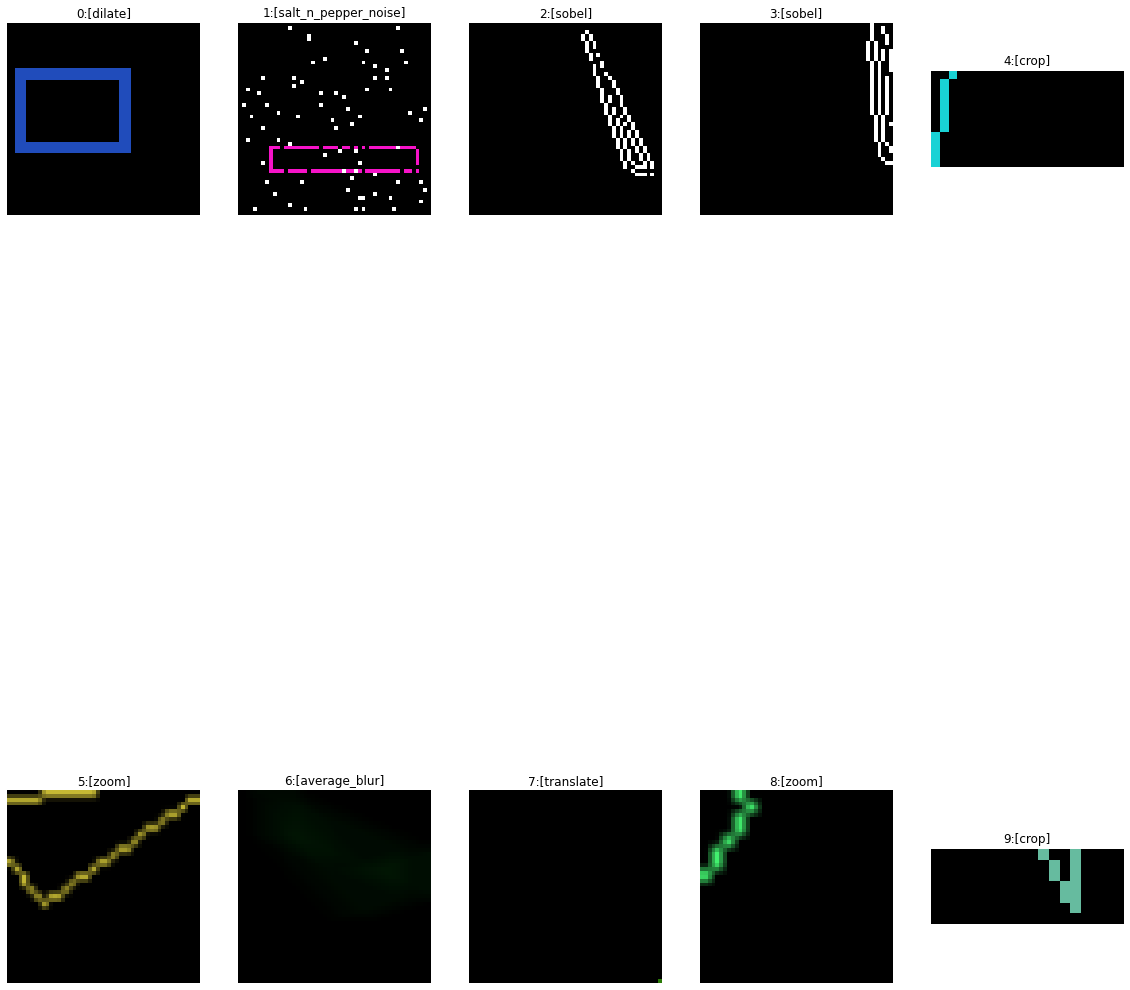

In [0]:
ra = RandomAugmentation(X_train[:10],N=RandomAugmentation.augmentations,M=None)
ra.generate_augmented_images(1,True)

### בדומה לסעיף 1 בניתי מחלקה אשר תבנה בסיס נתונים של צורות :משולש מלבן ואליפסה/עיגול. לאחר אתחול המחלקה ניתן לבקש ממנה לטעון את הנתונים, בבקשה זו המחלקה מערבבת את הנתונים שיצרה ומחזירה אותה בצורה שהתבקשנו. לאחר הטעינה השתמשתי במחלקת האוגמנטציות שנבנתה בסעיף קודם להצגת הצורות שהמחלקה ייצרה לנו.


In [0]:
load_mnist_data?

In [2]:
!wget https://images.daznservices.com/di/library/GOAL/8e/59/neymar-paris-saint-germain_7fb4mh5gxjyv1x7xmsccdq76o.png?t=-907256048&quality=60&w=1600 -O neymar.jpg


/bin/bash: -O: command not found
--2020-04-12 16:38:16--  https://images.daznservices.com/di/library/GOAL/8e/59/neymar-paris-saint-germain_7fb4mh5gxjyv1x7xmsccdq76o.png?t=-907256048
Resolving images.daznservices.com (images.daznservices.com)... 184.28.63.244
Connecting to images.daznservices.com (images.daznservices.com)|184.28.63.244|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1840833 (1.8M) [image/png]
Saving to: ‘neymar-paris-saint-germain_7fb4mh5gxjyv1x7xmsccdq76o.png?t=-907256048’

neymar-paris-saint- 100%[===================>]   1.75M  2.68MB/s    in 0.7s    

2020-04-12 16:38:17 (2.68 MB/s) - ‘neymar-paris-saint-germain_7fb4mh5gxjyv1x7xmsccdq76o.png?t=-907256048’ saved [1840833/1840833]



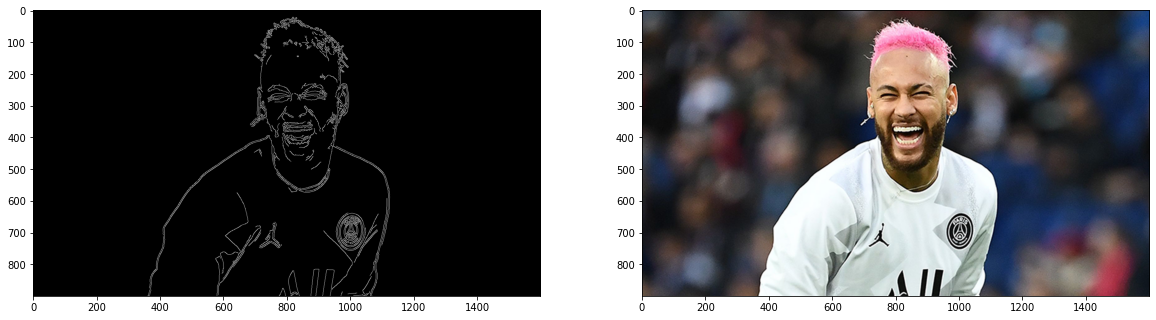

In [12]:

img = (plt.imread('neymar.png')*255).astype('uint8')
plt.figure(figsize=[20,20])
plt.subplot(121)
plt.imshow(cv2.Canny(img,100,250),cmap = 'gray')
plt.subplot(122)
plt.imshow(img)
plt.show()